In [59]:
import torchaudio
import numpy as np
import os
from IPython import display as disp
import matplotlib.pyplot as plt
import seaborn as sns

from bokeh.plotting import figure
from bokeh.io import output_notebook, show

output_notebook()
%matplotlib inline

Loading BokehJS ...

In [63]:
def bokeh_vis(wav):
    p = figure(width=1400, height=400, title="hello world")
    p.line(np.arange(wav.shape[0]), wav, line_width=2)
    show(p)

In [64]:
# PATH_ROBOT_NOISE = "/home/docker_current/src/datasets/robot_noise/robot_noise_1677428614.wav"
PATH_ROBOT_NOISE = "/home/docker_current/src/datasets/robot_noise/robot_noise_1677429557.wav"

In [65]:
noise, sr = torchaudio.load(PATH_ROBOT_NOISE)
print("audio length in seconds = ", noise.shape[1] / sr )

audio length in seconds =  929.28


In [71]:
print(noise.mean())
bokeh_vis(noise[0, 0:10000].numpy())

tensor(-1.6843e-05)


#### В эксперименте известны 2 сигнала: $X_{noise}$ и $X_{signal+noise}$
#### Необходимо определить: $$SNR = \frac{P_{signal}}{P_{noise}} = \frac{E(S^2) }{E(N^2) } $$  
#### При этом известны $E(N^2)$ и $E((S+N)^2)$, а  $E(S^2)$ неизвестно 
#### $E((S+N)^2)$ можно расписать как: $$ E((S+N)^2) = E(S^2) + E(N^2) + 2E(S)E(N) $$ 
#### Тогда при условии $E(N)=0$ будет справедливо равеноство: $$ E(S^2) = E((S+N)^2) - E(N^2)  $$

#### Определение $E(N)$ - матожидание наблюдаемого шума

In [72]:
def get_intervals(data, sr, length_in_seconds=3, n_intervals=1000):
    data_length = data.shape[1] // sr 
    max_probably_start = int((data_length - length_in_seconds) * sr)
    probability_start = np.arange(max_probably_start)
    
    intervals = []
    for _ in range(n_intervals):
        index_start = np.random.choice(probability_start)
        interval = data[0, index_start : index_start+length_in_seconds*sr]
        intervals.append(interval)
        
    return intervals

In [73]:
length_in_seconds = [1, 3, 5, 20]

for length in length_in_seconds:
    intervals = get_intervals(noise, sr, length_in_seconds=length)
    means = [i.mean() for i in intervals]
    E = sum(means) / len(means)
    print(f"Матожидание E(N) для интервалов длины {length} равно {E}")

Матожидание E(N) для интервалов длины 1 равно -1.6664036593283527e-05
Матожидание E(N) для интервалов длины 3 равно -1.6802630852907896e-05
Матожидание E(N) для интервалов длины 5 равно -1.6861253243405372e-05
Матожидание E(N) для интервалов длины 20 равно -1.6848574887262657e-05


#### Матожидание порядка $10^{-5}$ можно считать близким к 0, т.е. можно считать, что $E(N)=0$ 

#### Посмотрим на wave-форму записи голоса

In [99]:
PATH_VOICE = "/home/docker_current/src/datasets/asr_dataset/pushkarev/simple_comands.wav"

In [100]:
voice, sr = torchaudio.load(PATH_VOICE)
print("audio length in seconds = ", voice.shape[1] / sr )

audio length in seconds =  159.808


In [101]:
disp.display(disp.Audio(voice[0, 0:300000], rate=sr))

bokeh_vis(voice[0, 0:300000].numpy())

In [78]:
bokeh_vis(voice[0, 0:40000].numpy())

#### Наблюдаем проблему, что голос есть только на некоторых интервалах сигнала, на остальных же интервалах есть только шум
#### Поэтому необходимо выделить из сигнала только те отрезки, на которых есть голосовая активность (это делается с помощью модели VAD - в ноутбуке $\textbf{vad.ipynb}$)

In [81]:
def get_all_wav_paths(FOLDER_DATASET):
    speakers = os.listdir(FOLDER_DATASET)
    paths = []
    for speaker in speakers:
        wavs = os.listdir(os.path.join(FOLDER_DATASET, speaker, "parts")) 
        for wav in wavs:
            path = os.path.join(FOLDER_DATASET, speaker, "parts", wav)
            paths.append(path)
    return paths

In [82]:
FOLDER_DATASET = "/home/docker_current/src/datasets/asr_dataset"
all_wav_paths = get_all_wav_paths(FOLDER_DATASET)

In [96]:
disp_audio = all_wav_paths[99]

wav, sr = torchaudio.load(disp_audio)

disp.display(disp.Audio(disp_audio))
print(disp_audio)
bokeh_vis(wav[0, :].numpy())

/home/docker_current/src/datasets/asr_dataset/petryashin/parts/texts_16.wav


In [87]:
def get_noise_samples(data, n_samples):
    '''input - torch.Tensor with shape [1, N]
       output - torch.Tensor with shape [1, n_samples]'''
    data_length = data.shape[1] 
    max_probably_start = data_length - n_samples - 1
    probability_start = np.arange(max_probably_start)
    
    index_start = np.random.choice(probability_start)
    interval = data[0, index_start : index_start + n_samples]
            
    return interval.unsqueeze(0)
  
def get_power(signal):
    return (signal**2).sum()

def determ_snr(wav, noise_sample):
    P_n = get_power(noise_sample)
    P_s = get_power(wav) - P_n
    snr = P_s / P_n
    snr_db = 10 * np.log10(snr)
    return snr_db    

In [88]:
snrs = []
anomaly_wavs = []

for i in all_wav_paths:
    wav, sr = torchaudio.load(i)
    noise_sample = get_noise_samples(noise, wav.shape[1])
    snr = determ_snr(wav, noise_sample)
    snrs.append(snr)
    if snr < 10:
        anomaly_wavs.append(i)

Text(0.5, 1.0, 'SNR = 15.009474754333496 +- 3.307539224624634')

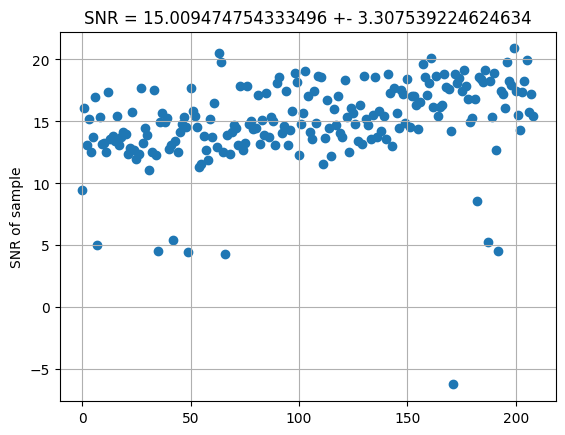

In [89]:
plt.figure()
plt.scatter(range(len(snrs)), snrs)
plt.grid()
plt.ylabel("SNR of sample")
plt.title(f"SNR = {np.mean(snrs)} +- {np.std(snrs)}")

#### Заметим явные выбросы и посмотрим на них  
#### При прослушивании заметим, что данным выбросам соответствуют записи, на которых нет адекватной голосовой активности
#### Исходя из этого такие данные можно отбросить и посчитать статистику заново

In [90]:
for i in anomaly_wavs:
    disp.display(disp.Audio(i))

Text(0.5, 1.0, 'SNR = 15.514409065246582 +- 2.204263687133789')

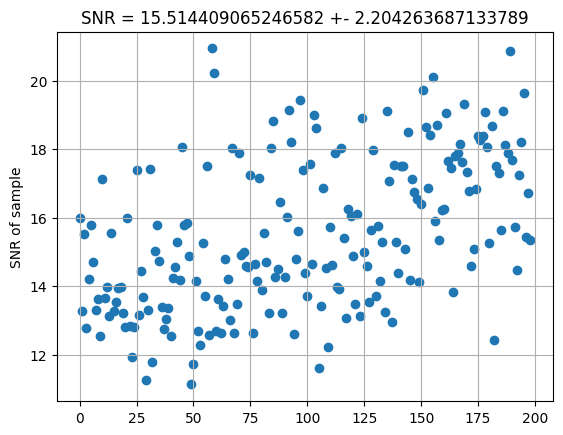

In [91]:
snrs = []

for i in all_wav_paths:
    wav, sr = torchaudio.load(i)
    noise_sample = get_noise_samples(noise, wav.shape[1])
    snr = determ_snr(wav, noise_sample)
    if snr >=10:
        snrs.append(snr)
        
plt.figure()
plt.scatter(range(len(snrs)), snrs)
plt.grid()
plt.ylabel("SNR of sample")
plt.title(f"SNR = {np.mean(snrs)} +- {np.std(snrs)}")